In [ ]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData

In [ ]:

df=pd.read_csv('finalized_data.csv')

In [ ]:
df['score'] = df['score'].round(2)

Disease Specificity Index
There are genes (or variants) that are associated with multiple diseases (e.g., TNF) while others are associated with a small set of diseases or even to a single disease. The Disease Specificity Index (DSI) is a measure of this property of the genes (and variants). It reflects if a gene (or variant) is associated to several or fewer diseases.

Disease Pleiotropy Index
The rationale is similar to the DSI, but we consider if the multiple diseases associated with the gene (or variant) are similar among them (belong to the same MeSH disease class, e.g., Cardiovascular Diseases) or are completely different diseases and belong to different disease classes.

In [ ]:

df = df.drop_duplicates()
print(f"Number of lines after removing duplicates: {len(df)}")


In [ ]:
import torch
from torch_geometric.data import HeteroData

# Assuming df is your DataFrame

# Prepare gene node features using gene_index as indices
genes = df[['gene_index', 'geneDSI', 'geneDPI']].drop_duplicates().set_index('gene_index')
num_genes = genes.index.max() + 1  # Assuming indices start from 0
gene_features = torch.zeros((num_genes, 2), dtype=torch.float)
gene_features[genes.index] = torch.tensor(genes[['geneDSI', 'geneDPI']].values, dtype=torch.float)

# Prepare disease nodes
diseases = df[['disease_index']].drop_duplicates().set_index('disease_index')
num_diseases = diseases.index.max() + 1  # Assuming indices start from 0

# Prepare edge indices using existing indices
edge_index = torch.tensor([
    df['gene_index'].values,
    df['disease_index'].values
], dtype=torch.long)

# Edge attributes (scores)
edge_attr = torch.tensor(df['score'].values, dtype=torch.float).unsqueeze(1)

# Create HeteroData object
data = HeteroData()

# Add gene node features
data['gene'].x = gene_features

# Set the number of disease nodes (no features)
data['disease'].num_nodes = num_diseases

# Add edges between genes and diseases with edge attributes
data['gene', 'associates_with', 'disease'].edge_index = edge_index
data['gene', 'associates_with', 'disease'].edge_attr = edge_attr

In [ ]:
data

In [ ]:
import torch_geometric.transforms as T
# Add reverse edges to allow message passing in both directions
# Convert the graph to undirected (adds reverse edges)
data = T.ToUndirected()(data)

# Define the edge types for splitting
edge_types = ('gene', 'associates_with', 'disease')
rev_edge_types = ('disease', 'rev_associates_with', 'gene')  # Reverse edge type

# Perform RandomLinkSplit with corrected parameter
transform = T.RandomLinkSplit(
    num_val=0.1,                     # 10% for validation
    num_test=0.1,                    # 10% for testing
    disjoint_train_ratio=0.3,        # 30% of training edges for supervision
    neg_sampling_ratio=2.0,          # Negative edge ratio for evaluation
    is_undirected=True,              # Graph is undirected
    add_negative_train_samples=False,  # Negative edges generated on-the-fly during training
    edge_types=edge_types,
    rev_edge_types=rev_edge_types,
)

In [ ]:
train_data, val_data, test_data = transform(data)

In [ ]:
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

print("Training data edges (gene -> disease):", train_data["gene", "associates_with", "disease"].num_edges)
print("Training data edge label index size:", train_data["gene", "associates_with", "disease"].edge_label_index.size(1))
print("Training data edges (disease -> gene):", train_data["disease", "rev_associates_with", "gene"].num_edges)
print("Training data edge label min:", train_data["gene", "associates_with", "disease"].edge_label.min())
print("Training data edge label max:", train_data["gene", "associates_with", "disease"].edge_label.max())

print("Validation data edges (gene -> disease):", val_data["gene", "associates_with", "disease"].num_edges)
print("Validation data edge label index size:", val_data["gene", "associates_with", "disease"].edge_label_index.size(1))
print("Validation data edges (disease -> gene):", val_data["disease", "rev_associates_with", "gene"].num_edges)
print("Validation data edge label bincount:", val_data["gene", "associates_with", "disease"].edge_label.long().bincount().tolist())


In [ ]:
for split_name, split_data in [('Train', train_data), ('Validation', val_data), ('Test', test_data)]:
    edge = split_data['gene', 'associates_with', 'disease']
    print(f"{split_name} Data:")
    print(f"  edge_label_index shape: {edge.edge_label_index.shape}")
    print(f"  edge_label shape: {edge.edge_label.shape}")
    print(f"  Max edge_label_index: {edge.edge_label_index.max().item()}")
    print()

In [ ]:
from torch_geometric.loader import LinkNeighborLoader

# Define the edge type for link prediction
edge_label_index = ('gene', 'associates_with', 'disease')

# Training data loader
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[10, 5],
    batch_size=128,
    edge_label_index=(
        edge_label_index,
        train_data[edge_label_index].edge_label_index
    ),
    edge_label=train_data[edge_label_index].edge_label,
    neg_sampling_ratio=2.0,
    shuffle=True
)

# Validation data loader
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[10, 5],
    batch_size=128,
    edge_label_index=(
        edge_label_index,
        val_data[edge_label_index].edge_label_index
    ),
    edge_label=val_data[edge_label_index].edge_label,
    shuffle=False
)

# Test data loader
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[10, 5],
    batch_size=128,
    edge_label_index=(
        edge_label_index,
        test_data[edge_label_index].edge_label_index
    ),
    edge_label=test_data[edge_label_index].edge_label,
    shuffle=False
)



# Verify a few things

In [ ]:
batch = next(iter(train_loader))
print("Batch edge_label_index shape:", batch[edge_label_index].edge_label_index.shape)
print("Batch edge_label shape:", batch[edge_label_index].edge_label.shape)
print("Batch positive labels:", (batch[edge_label_index].edge_label == 1).sum().item())
print("Batch negative labels:", (batch[edge_label_index].edge_label == 0).sum().item())

3. Check the distribution of edge labels

Count the number of positive and negative labels to ensure they are correctly assigned.

In [ ]:
for split_name, split_data in [('Train', train_data), ('Validation', val_data), ('Test', test_data)]:
    edge = split_data['gene', 'associates_with', 'disease']
    labels = edge.edge_label
    pos_labels = (labels == 1).sum().item()
    neg_labels = (labels == 0).sum().item()
    print(f"{split_name} Data:")
    print(f"  Positive labels (edges): {pos_labels}")
    print(f"  Negative labels (non-edges): {neg_labels}")
    print()

4. Inspect a small sample of edges and labels

View a few edges and their corresponding labels to manually verify correctness.

In [ ]:
split_data = train_data  # Replace with val_data or test_data as needed
edge = split_data['gene', 'associates_with', 'disease']

# View the first 5 edges and labels
print("First 5 edges:")
print(edge.edge_label_index[:, :5])
print("Corresponding labels:")
print(edge.edge_label[:5])

5. Verify that positive edges correspond to actual connections

For a few positive labels, confirm that the edges exist in original DataFrame or data object

In [ ]:
# Assuming you have access to the original edge indices
original_edges = data['gene', 'associates_with', 'disease'].edge_index

# Compare with the training edges
train_edges = train_data['gene', 'associates_with', 'disease'].edge_label_index

# Check if training edges are a subset of original edges
edge_pairs = set(map(tuple, original_edges.t().tolist()))
train_edge_pairs = set(map(tuple, train_edges.t().tolist()))
print("All training edges are in the original edges:", train_edge_pairs.issubset(edge_pairs))

6. Confirm that negative samples are not in the original edges
For validation and test splits, ensure that negative samples do not exist in the actual graph

In [ ]:
split_name = 'Validation'  # or 'Test'
split_data = val_data if split_name == 'Validation' else test_data
edge = split_data['gene', 'associates_with', 'disease']

# Get negative edge indices
neg_edge_indices = edge.edge_label_index[:, edge.edge_label == 0]

# Convert to set of edge pairs
neg_edge_pairs = set(map(tuple, neg_edge_indices.t().tolist()))

# Check if any negative edges are in the original edges
common_edges = neg_edge_pairs.intersection(edge_pairs)
print(f"Number of negative {split_name.lower()} edges in original edges:", len(common_edges))

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class LinkPredictor(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x_gene, x_disease, edge_label_index):
        row, col = edge_label_index
        x = torch.cat([x_gene[row], x_disease[col]], dim=-1)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return x.squeeze()

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        
        # Gene features: DSI and DPI (2 features)
        self.gene_lin = torch.nn.Linear(2, hidden_channels)
        
        # Disease has no features, learn embeddings
        self.disease_emb = torch.nn.Embedding(23, hidden_channels)  # 23 diseases
        
        # GNN for learning node representations
        self.gnn = GNN(hidden_channels)
        
        # Convert to heterogeneous GNN
        self.gnn = to_hetero(self.gnn, data.metadata())
        
        # Link predictor
        self.predictor = LinkPredictor(hidden_channels)

    def forward(self, data):
        x_dict = {
            'gene': self.gene_lin(data['gene'].x),
            'disease': self.disease_emb(torch.arange(data['disease'].num_nodes).to(data['gene'].x.device))
        }

        # Apply GNN
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        # Predict links
        return self.predictor(
            x_dict['gene'],
            x_dict['disease'],
            data['gene', 'associates_with', 'disease'].edge_label_index,
        )

# Initialize model
model = Model(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
print(model)

In [ ]:
# Device setup
from sklearn.metrics import roc_auc_score
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_losses = []
val_aucs = []
test_aucs = []


def train_epoch():
    model.train()
    total_loss = 0
    num_of_batches = 0
    for batch in train_loader:
        # Move batch to device
        batch = batch.to(device)
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        pred = model(batch)
        # Get labels and compute loss
        target = batch['gene', 'associates_with', 'disease'].edge_label.float()
        loss = criterion(pred, target)    
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += float(loss) * pred.size(0)
        num_of_batches += 1
    train_losses.append(total_loss / (num_of_batches * train_loader.batch_size))
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    preds = []
    ground_truths = []
    
    # Add progress bar
    for batch in tqdm.tqdm(loader):
        batch = batch.to(device)
        pred = model(batch)
        preds.append(pred.sigmoid().cpu())
        ground_truths.append(batch['gene', 'associates_with', 'disease'].edge_label.cpu())
    
    pred_all = torch.cat(preds, dim=0).numpy()
    label_all = torch.cat(ground_truths, dim=0).numpy()
    return roc_auc_score(label_all, pred_all)

# Training loop
num_epochs = 100
best_val_auc = 0
patience = 10
counter = 0

for epoch in range(num_epochs):
    # Training
    loss = train_epoch()
    
    # Evaluation
    val_auc = evaluate(val_loader)
    test_auc = evaluate(test_loader)
    val_aucs.append(val_auc)
    test_aucs.append(test_auc)
    
    # Print metrics
    print(f'Epoch {epoch:03d}:')
    print(f'Train Loss: {loss:.4f}')
    print(f'Val AUC: {val_auc:.4f}')
    print(f'Test AUC: {test_auc:.4f}')
    
    # Early stopping with model checkpoint
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping!')
            break

# Load best model and get final evaluate score
model.load_state_dict(torch.load('best_model.pt'))
final_test_auc = evaluate(test_loader)
print(f'Final Test AUC: {final_test_auc:.4f}')

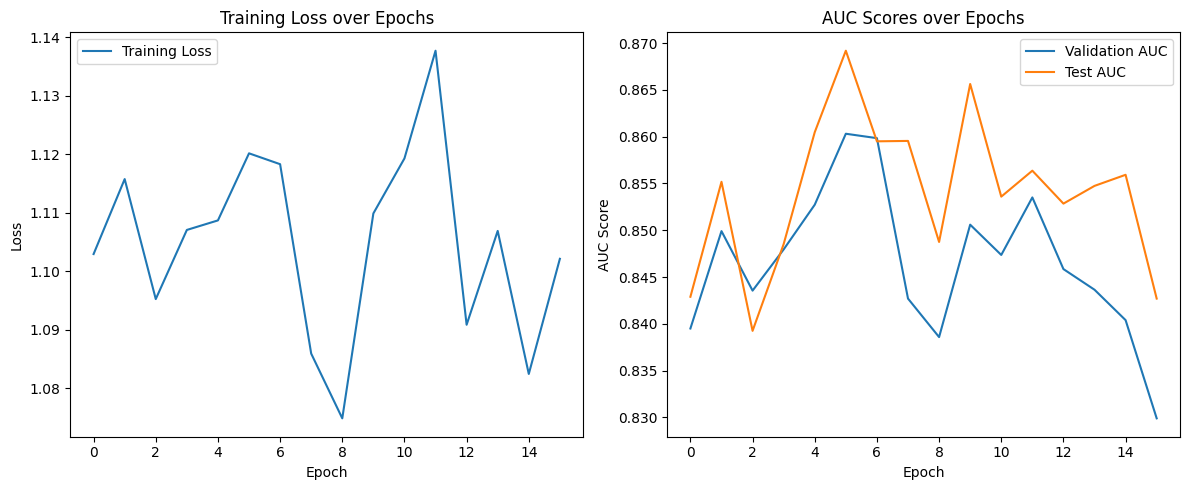

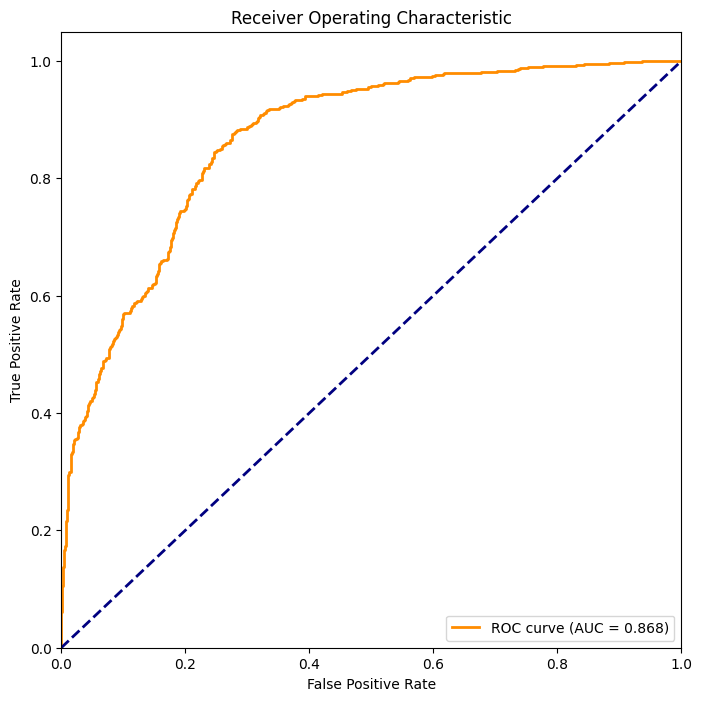

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# 1. Training Progress Plots
def plot_training_progress(train_losses, val_aucs, test_aucs):
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    
    # Plot AUC scores
    plt.subplot(1, 2, 2)
    plt.plot(val_aucs, label='Validation AUC')
    plt.plot(test_aucs, label='Test AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.title('AUC Scores over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 2. ROC Curve
@torch.no_grad()
def plot_roc_curve(loader, model, device):
    model.eval()
    preds = []
    labels = []
    
    for batch in loader:
        batch = batch.to(device)
        pred = model(batch)
        preds.append(pred.sigmoid().cpu())
        labels.append(batch['gene', 'associates_with', 'disease'].edge_label.cpu())
    
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# 3. Save metrics to file
def save_metrics(train_losses, val_aucs, test_aucs):
    metrics_dict = {
        'train_loss': train_losses,
        'val_auc': val_aucs,
        'test_auc': test_aucs
    }
    np.save('training_metrics.npy', metrics_dict)

# Call the visualization functions
plot_training_progress(train_losses, val_aucs, test_aucs)
plot_roc_curve(test_loader, model, device)
save_metrics(train_losses, val_aucs, test_aucs)

C:\Users\Marci\AppData\Local\Temp\ipykernel_18588\3748285088.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))



Top 20 Predicted Gene-Disease Associations:
     gene_ncbi       disease_name  prediction_score
552        673  Colorectal Cancer          0.939314
235       1499  Colorectal Cancer          0.938694
103       3845  Colorectal Cancer          0.933938
149       4914     Schizophrenias          0.917773
271        324  Colorectal Cancer          0.903411
91        4089  Colorectal Cancer          0.899851
485        207      Breast Cancer          0.896749
89        7124      Breast Cancer          0.891617
585       5290      Breast Cancer          0.891325
101       1312     Schizophrenias          0.886728
576       3320      Breast Cancer          0.882909
506       7057      Breast Cancer          0.882617
375         25  Colorectal Cancer          0.881479
299       4436  Colorectal Cancer          0.881220
144       2735      Breast Cancer          0.880970
529      11186      Breast Cancer          0.880603
469       4323      Breast Cancer          0.877447
577       9076     

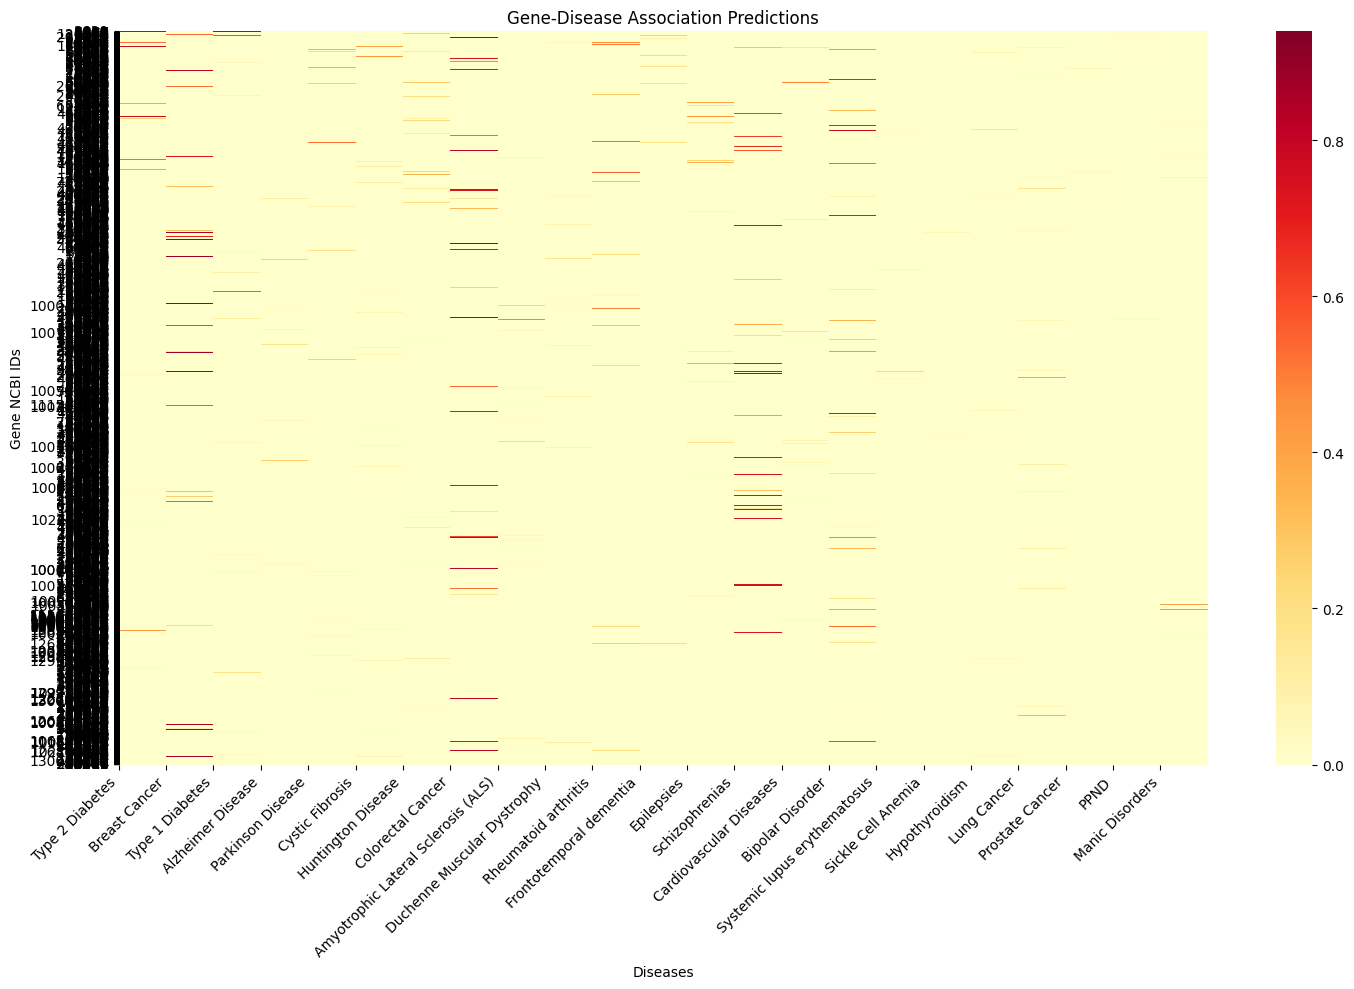

In [77]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Read mappings from CSV
df = pd.read_csv('finalized_data.csv')

# Create gene and disease mappings
gene_to_idx = dict(zip(df['geneNcbiID'].unique(), range(len(df['geneNcbiID'].unique()))))
idx_to_gene = {v: k for k, v in gene_to_idx.items()}
disease_to_idx = dict(zip(df['diseaseName'].unique(), range(len(df['diseaseName'].unique()))))
idx_to_disease = {v: k for k, v in disease_to_idx.items()}

@torch.no_grad()
def get_readable_predictions(model, data, device):
    model.eval()
    model = model.to(device)
    data = data.to(device)
    
    # Get predictions
    pred = model(data)
    pred = pred.sigmoid().cpu().numpy()
    
    # Get edge indices
    edge_index = data['gene', 'associates_with', 'disease'].edge_label_index.cpu().numpy()
    
    # Create DataFrame with predictions and names
    df_pred = pd.DataFrame({
        'gene_idx': edge_index[0],
        'disease_idx': edge_index[1],
        'gene_ncbi': [idx_to_gene[idx] for idx in edge_index[0]],
        'disease_name': [idx_to_disease[idx] for idx in edge_index[1]],
        'prediction_score': pred
    })
    
    return df_pred

# Load best model and get predictions
model.load_state_dict(torch.load('best_model.pt'))
predictions_df = get_readable_predictions(model, test_data, device)

# Display top predictions
print("\nTop 20 Predicted Gene-Disease Associations:")
print(predictions_df.sort_values('prediction_score', ascending=False)
      .head(20)[['gene_ncbi', 'disease_name', 'prediction_score']])

# Create heatmap
plt.figure(figsize=(15, 10))
gene_names = [str(idx_to_gene[i]) for i in range(len(idx_to_gene))]
disease_names = [idx_to_disease[i] for i in range(len(idx_to_disease))]

predictions_matrix = np.zeros((len(gene_names), len(disease_names)))
for _, row in predictions_df.iterrows():
    predictions_matrix[int(row['gene_idx']), int(row['disease_idx'])] = row['prediction_score']

sns.heatmap(predictions_matrix, cmap='YlOrRd')
plt.title('Gene-Disease Association Predictions')
plt.xlabel('Diseases')
plt.ylabel('Gene NCBI IDs')
plt.xticks(np.arange(len(disease_names)), disease_names, rotation=45, ha='right')
plt.yticks(np.arange(len(gene_names)), gene_names)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
import os

def get_and_save_novel_predictions(model, data, device, batch_size=1024, output_file='novel_predictions.csv'):
    model.eval()
    known_edges = set(map(tuple, data['gene', 'associates_with', 'disease'].edge_index.t().tolist()))
    
    # Setup CSV file with headers if it doesn't exist
    if not os.path.exists(output_file):
        pd.DataFrame(columns=['gene_idx', 'disease_idx', 'gene_ncbi', 'disease_name', 'prediction_score']).to_csv(output_file, index=False)
    
    try:
        # Generate novel pairs
        novel_pairs = []
        print("Generating novel pairs...")
        for g in range(data['gene'].num_nodes):
            for d in range(data['disease'].num_nodes):
                if (g, d) not in known_edges:
                    novel_pairs.append([g, d])
        
        # Process in batches
        print("Processing predictions in batches...")
        for i in tqdm(range(0, len(novel_pairs), batch_size)):
            batch_pairs = novel_pairs[i:i+batch_size]
            batch_tensor = torch.tensor(batch_pairs, dtype=torch.long).t().to(device)
            
            # Get predictions
            with torch.no_grad():
                batch_pred = model(data)
                pred_probs = batch_pred.sigmoid().cpu().numpy()
            
            # Filter predictions > 0.5 and create batch DataFrame
            batch_results = []
            for j, (pair, prob) in enumerate(zip(batch_pairs, pred_probs)):
                if prob >= 0.5:
                    batch_results.append({
                        'gene_idx': pair[0],
                        'disease_idx': pair[1],
                        'gene_ncbi': idx_to_gene[pair[0]],
                        'disease_name': idx_to_disease[pair[1]],
                        'prediction_score': prob
                    })
            
            # Save batch results if any predictions > 0.5
            if batch_results:
                batch_df = pd.DataFrame(batch_results)
                batch_df.to_csv(output_file, mode='a', header=False, index=False)
    
    except KeyboardInterrupt:
        print("\nProcess interrupted. Partial results saved.")
    except Exception as e:
        print(f"\nError occurred: {str(e)}. Partial results saved.")
    
    # Read and return top 10 predictions
    final_df = pd.read_csv(output_file)
    top_10 = final_df.nlargest(10, 'prediction_score')
    return top_10

# Execute
print("Starting prediction generation...")
top_predictions = get_and_save_novel_predictions(model, test_data, device)
print("\nTop 10 Novel Predictions (score >= 0.5):")
print(top_predictions[['gene_ncbi', 'disease_name', 'prediction_score']])